In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from datetime import datetime

from matplotlib import pyplot as plt
from matplotlib import image as img
from matplotlib.offsetbox import AnchoredText
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.plotting import plot_lifetimes

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from lifelines.statistics import multivariate_logrank_test

plt.rcParams.update({"xtick.labelsize": 6,
                     "ytick.labelsize": 6,
                    })

In [2]:
df = pd.read_csv('./heart_failure_clinical_records_dataset.csv', sep=',')

In [3]:
# df = df[df['time'] > 100]

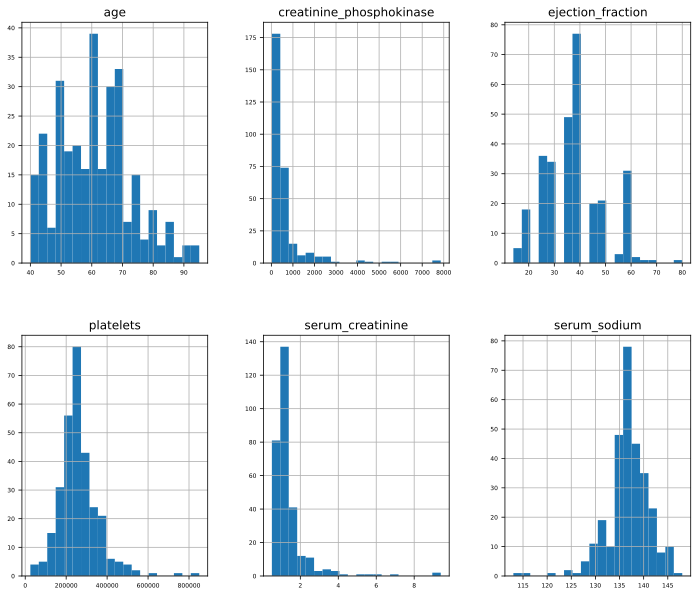

In [4]:
df_num_features = df.drop(columns=['anaemia', 'diabetes', 'high_blood_pressure', 
                                         'sex', 'smoking', 'DEATH_EVENT', 'time'])
df_num_features.hist(figsize=(12, 10), bins=20, grid=True, layout=(-1, 3));

In [5]:
df["ejection_fraction_cat"] = 0
df.loc[(df['ejection_fraction'] <= 35), 'ejection_fraction_cat'] = 1
df["ejection_fraction_cat"].value_counts()

df["age_cat"] = 0
df.loc[(df['age'] >= 60), 'age_cat'] = 1
df["age_cat"].value_counts()

1    170
0    129
Name: age_cat, dtype: int64

In [6]:
feature_names = df.drop(df_num_features, axis=1)
feature_names_cat = feature_names.drop(['DEATH_EVENT', 'time'], axis=1).columns.tolist()
feature_names_cat

['anaemia',
 'diabetes',
 'high_blood_pressure',
 'sex',
 'smoking',
 'ejection_fraction_cat',
 'age_cat']

In [7]:
df_num_features.columns

Index(['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets',
       'serum_creatinine', 'serum_sodium'],
      dtype='object')

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

my_dictiniary = {'age': range(40, 100, 2), 
                 'creatinine_phosphokinase': range(1, 4000, 100), 
                 'ejection_fraction': range(10, 70, 1), 
                 'platelets': range(100000, 200000, 10000),
                 'serum_creatinine': range(0, 8, 1), 
                 'serum_sodium': range(110, 150, 2),
                }

for i in df_num_features.columns:
    x_test = df[i]
    y_test = df['DEATH_EVENT']
    roc_dictionary = {}
    for a in my_dictiniary[i]:
        for index in range(len(x_test)):
            if x_test[index] > a:
                x_test[index] = 1
            else:
                x_test[index] = 0
        roc_auc = roc_auc_score(y_test, x_test)
        roc_dictionary[a] = roc_auc
        optimum = max(roc_dictionary, key=roc_dictionary.get)
    my_dictiniary[i] = [optimum, roc_dictionary[optimum]]
my_dictiniary

{'age': [40, 0.5172413793103448],
 'creatinine_phosphokinase': [1, 0.5],
 'ejection_fraction': [10, 0.5],
 'platelets': [110000, 0.5],
 'serum_creatinine': [0, 0.5],
 'serum_sodium': [110, 0.5]}

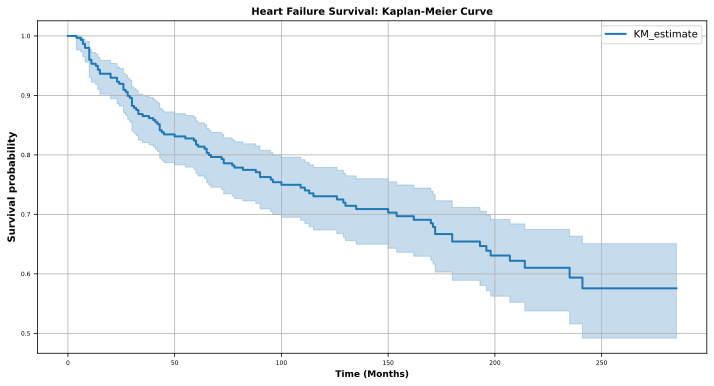

In [9]:
kmf = KaplanMeierFitter()
kmf.fit(df['time'], df['DEATH_EVENT'])
kmf.plot(linewidth=2, figsize=(12, 6))
plt.title('Heart Failure Survival: Kaplan-Meier Curve', fontsize=10, fontweight='bold')
plt.xlabel('Time (Months)', fontsize=9, fontweight='bold')
plt.ylabel('Survival probability', fontsize=10, fontweight='bold')
plt.grid()

plt.show()

In [10]:
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
4.0,0.996656
6.0,0.993311
7.0,0.986622
8.0,0.979933
...,...
270.0,0.575705
271.0,0.575705
278.0,0.575705


In [11]:
for feature in feature_names_cat:
    if feature == 'sex':
        feature_names[feature] = feature_names[feature].replace({1: 'Женский', 0: 'Мужской'})
    else:
        feature_names[feature] = feature_names[feature].replace({1: 'Да', 0: 'Нет'})

In [12]:
my_dict = {
    'anaemia': 'Анемия',
    'diabetes': 'Диабет',
    'high_blood_pressure': 'Повышенное АД',
    'sex': 'Пол',
    'smoking': 'Курение',
    'ejection_fraction_cat': 'ФВ < 35%',
    'age_cat': 'Возраст старше 60 лет',
}

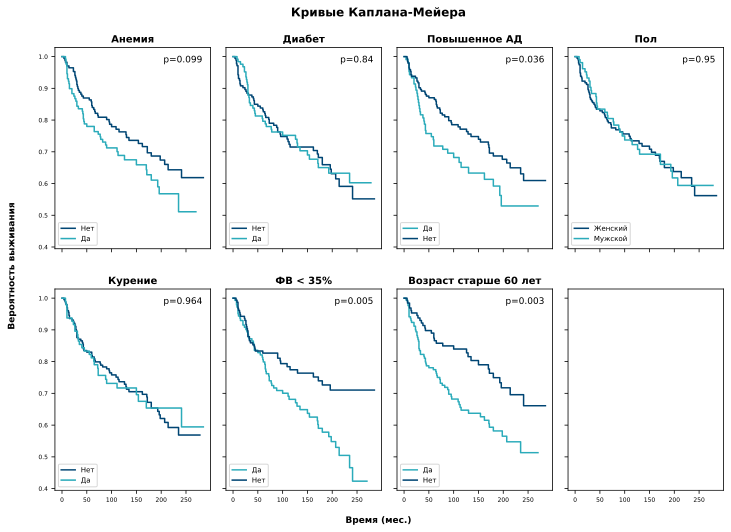

In [13]:
webiomed_palette = [
    (0.17, 0.67, 0.73),
    (0.19, 0.48, 0.60),
    (0.00, 0.27, 0.45)
]

colours = {'Да': webiomed_palette[0], 'Нет':webiomed_palette[2],  
           'Мужской': webiomed_palette[0], 'Женский': webiomed_palette[2]}  

fig, axes = plt.subplots(nrows = 2, ncols = 4, 
                         sharex = True, sharey = True,
                         figsize=(12, 8))

plt.xticks(np.arange(0, 290, 50))

def categorical_km_curves(feature, t='time', event='DEATH_EVENT', df=feature_names, ax=None):
    for cat in (df[feature].unique()):
        idx = df[feature] == cat
        kmf = KaplanMeierFitter()
        kmf.fit(df[idx][t], event_observed=df[idx][event], label=cat)
        kmf.plot(ax=ax, label=cat, ci_show=False, c=colours[cat])

for cat, ax in zip(feature_names_cat, axes.flatten()):
    categorical_km_curves(feature=cat, t='time', event='DEATH_EVENT', df = feature_names, ax=ax)
    ax.legend(loc='lower left', prop={'size': 7})
    ax.set_title(my_dict[cat], pad=5, fontsize=10, fontweight='bold')
    p = multivariate_logrank_test(feature_names['time'], feature_names[cat], feature_names['DEATH_EVENT'])
    ax.add_artist(AnchoredText(f"p={p.p_value.round(3)}", frameon=False, 
                               loc='upper right', prop=dict(size=9)))
    ax.set_xlabel('')
#     add_at_risk_counts(kmf, ax=ax, fig=fig, labels=[cat])
    
fig.subplots_adjust(wspace = 0.1)

fig.suptitle('Кривые Каплана-Мейера', fontsize = 12, fontweight='bold', y=0.95)
fig.supxlabel('Время (мес.)', fontsize = 9, fontweight='bold', y=0.05)
fig.supylabel('Вероятность выживания', fontsize = 9, fontweight='bold', x=0.07)

plt.savefig('Кривые Каплана-Мейера.png')
plt.show()

In [14]:
df_train, df_test = train_test_split(df, test_size=0.33, shuffle=True, random_state=100)
df_test = df_test.set_index(np.arange(len(df_test)))

In [15]:
df_train.drop(columns=['ejection_fraction_cat', 'age_cat'], inplace=True)

In [16]:
df_train

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
191,0.0,1,0,0,0,0,0.0,0.0,0,0,0,174,0
136,0.0,1,0,1,0,0,0.0,0.0,0,0,0,107,0
104,0.0,0,0,0,0,1,0.0,0.0,0,0,0,87,0
62,0.0,0,0,0,0,0,0.0,0.0,0,1,1,60,0
157,0.0,0,0,0,0,0,0.0,0.0,0,1,1,120,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,0.0,1,0,1,0,0,0.0,0.0,0,0,0,65,1
53,0.0,1,0,1,0,1,0.0,0.0,0,0,0,44,1
79,0.0,0,0,0,0,1,0.0,0.0,0,0,0,74,0
280,0.0,0,0,1,0,0,0.0,0.0,0,1,0,247,0


In [20]:
df_train

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
191,0.0,1,0,0,0,0,0.0,0.0,0,0,0,174,0
136,0.0,1,0,1,0,0,0.0,0.0,0,0,0,107,0
104,0.0,0,0,0,0,1,0.0,0.0,0,0,0,87,0
62,0.0,0,0,0,0,0,0.0,0.0,0,1,1,60,0
157,0.0,0,0,0,0,0,0.0,0.0,0,1,1,120,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,0.0,1,0,1,0,0,0.0,0.0,0,0,0,65,1
53,0.0,1,0,1,0,1,0.0,0.0,0,0,0,44,1
79,0.0,0,0,0,0,1,0.0,0.0,0,0,0,74,0
280,0.0,0,0,1,0,0,0.0,0.0,0,1,0,247,0


In [30]:
cph = CoxPHFitter()
cph.fit(df_train, duration_col='time', event_col='DEATH_EVENT')

plt.figure(figsize=(8, 6))
cph.plot()
plt.show()

ConvergenceError: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model

In [ ]:
survival_func_plot = cph.predict_survival_function(df_test)

plt.figure(figsize=(12, 7))
plt.plot(survival_func_plot.loc[:, 0:10])
plt.legend(labels=survival_func_plot.loc[:, 0:10].columns, loc ="lower left", ncol=4)

plt.grid()
plt.xlabel('Time (Months)', fontsize=9, fontweight='bold')
plt.title('Survival probability', fontsize=10, fontweight='bold')
plt.show()

In [ ]:
# for_prognosis = survival_func_plot.T
# estimated_term_in_month = 205

# try:
#     for_prognosis[estimated_term_in_month]
#     for_prognosis = pd.DataFrame(for_prognosis.loc[:][estimated_term_in_month].round(2))
    
#     for_prognosis['DEATH_EVENT_PROGNOSIS'] = 0
#     for_prognosis.loc[for_prognosis[estimated_term_in_month] < 0.5, 'DEATH_EVENT_PROGNOSIS'] = 1
#     preds = pd.DataFrame(for_prognosis['DEATH_EVENT_PROGNOSIS'])

#     y_test = pd.DataFrame(df_test[df_test['time'] > estimated_term_in_month]['DEATH_EVENT'])
    
#     df_final = y_test.merge(preds, how='outer', left_on=y_test.index, right_on=preds.index)
#     df_final = df_final.loc[~df_final['DEATH_EVENT'].isna()]
    
#     fpr, tpr, threshold = metrics.roc_curve(df_final['DEATH_EVENT'], df_final["DEATH_EVENT_PROGNOSIS"])
#     roc_auc = metrics.auc(fpr, tpr)

#     plt.figure(figsize=(12, 7))
#     plt.title('Receiver Operating Characteristic')
#     plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
#     plt.legend(loc = 'lower right')
#     plt.plot([0, 1], [0, 1],'r--')
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
#     plt.show()
    
# except:
#     print('Введите другой период в месяцах')